In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
import math
from sklearn.metrics import f1_score

In [6]:
#Info : 552 subjects, 21 waves, 8378 rows
df = pd.read_csv('Speed_Dating_Data.csv', encoding = "ISO-8859-1")

In [7]:
#there were 690 matches only out of a potential 4189 matches
matches = pd.crosstab(df['match'], columns = "count")
print(matches)

col_0  count
match       
0       6998
1       1380


In [8]:
data = pd.concat([df.iloc[:,0], #ID
                  df.iloc[:,2], #gender
                  df.iloc[:, 11:17], #partner's id, match, int_corr, samerace, age of partner, race of partner 
                  df.iloc[:,17:23], #stated preferences
                  df.iloc[:,23:24], #decision of partner
                  df.iloc[:,24:32],   # rating by partner for 6 attributes, probability of matching with partner #amb-o has lots of missing values - try eliminating
                  df.iloc[:,32:35], # met, age, field
                  df.iloc[:,39:42],#race, importance of race, importance of religion
                  df.iloc[:,42:43], #from   (DROPPED ZIPCODE AND INCOME AS THEY HAVE TOO MANY MISSING VALUES)
                  df.iloc[:,45:48], #goal, date, go_out
                  df.iloc[:,48:50], #career, career_coded
                  df.iloc[:,50:67], #interests
                  #df.iloc[:,67:69], #exphappy, expnum (DROPPED - TOO MANY MISSING VALUES)
                  df.iloc[:,69:74],  #what subject looks for in the opposite sex - 6 attributes
                  df.iloc[:,74:75],
                  df.iloc[:,81:87], #attr2_1,..
                  df.iloc[:,87:92], #91 is amb3_1
                  df.iloc[:,97:102], #decision, ratings for partner for the 6 attributes
                  #df.iloc[:,102:104], 
                  df.iloc[:,104:107]],axis=1)
                

#data.isnull().sum()
data = data.dropna()
print(np.shape(data))

(6041, 77)


In [312]:
data2 = pd.concat([#df.iloc[:,0], #ID
                  df.iloc[:,2], #gender
                  df.iloc[:,9:10], #order of date
                  df.iloc[:, 11:12], #partner's id
                  df.iloc[:, 12:13], #match, 
                  df.iloc[:,13:17], #int_corr, samerace, age of partner, race of partner 
                  df.iloc[:,17:23], #stated preferences
                  df.iloc[:,23:24], #decision of partner - dec-o
                  df.iloc[:,24:28], #attr_o..fun_o
                  df.iloc[:,28:32],
                  #df.iloc[:,24:32],   # rating by partner for 6 attributes, probability of matching with partner #amb-o has lots of missing values - try eliminating
                  #df.iloc[:,32:35], # met, age, field
                  df.iloc[:,39:42],#race, importance of race, importance of religion
                  #df.iloc[:,42:43], #from   (DROPPED ZIPCODE AND INCOME AS THEY HAVE TOO MANY MISSING VALUES)
                  df.iloc[:,45:48], #goal, date, go_out
                  #df.iloc[:,48:50], #career, career_coded
                  df.iloc[:,50:67], #interests
                  #df.iloc[:,67:69], #exphappy, expnum (DROPPED - TOO MANY MISSING VALUES)
                  df.iloc[:,69:74],  #what subject looks for in the opposite sex - 6 attributes
                  df.iloc[:,74:75],  #shar1_1
                  df.iloc[:,81:87], #attr2_1,..shar2_1
                  df.iloc[:,87:92],  #attr3_1.. #91 is amb3_1 (how do you measure up)
                  df.iloc[:,97:98], #decision of subject - dec
                  df.iloc[:,98:102], #ratings by subject for partner for the 6 attributes. 101 is fun
                  df.iloc[:,102:104], #amb,shar
                  df.iloc[:,104:107]],axis=1) #like, prob, met

data3 = data2.dropna()


# <font color='red'> corr() in pandas default to Pearson correlation, which assumes normal distribution</font>

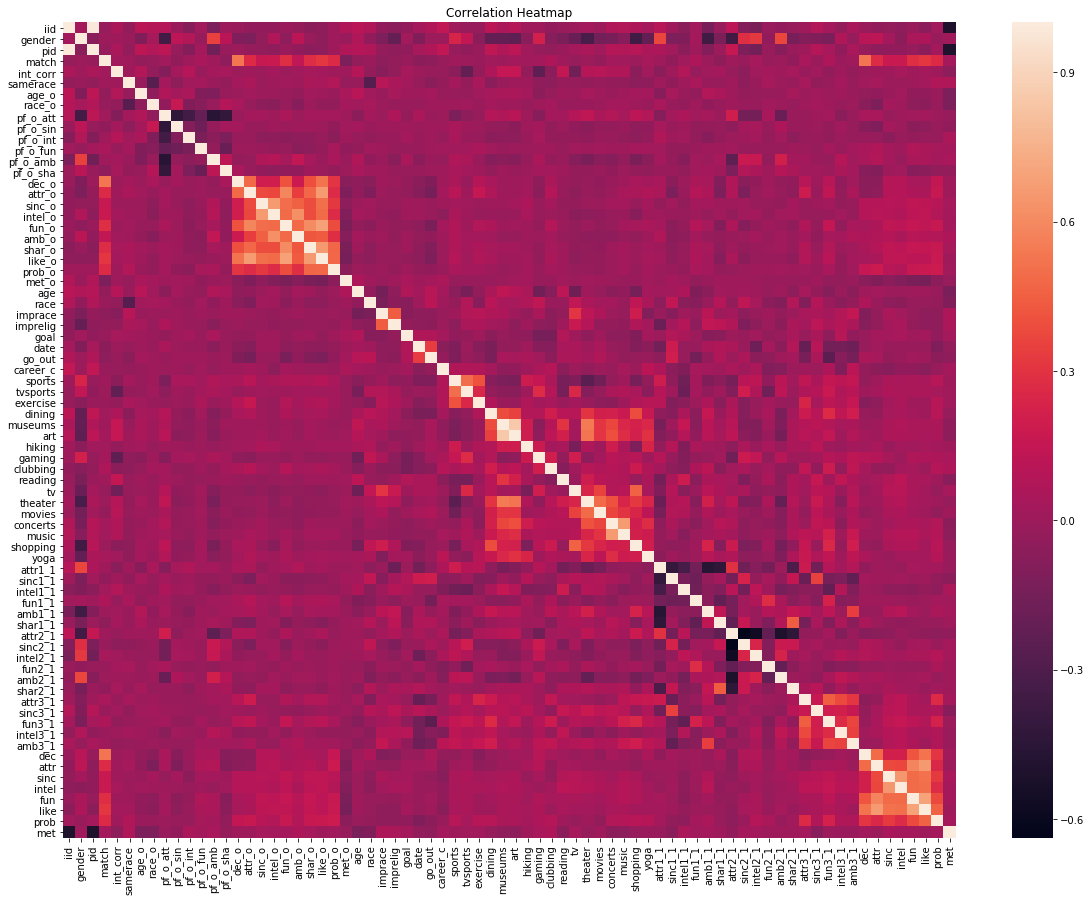

In [9]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = data.corr()
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)

#From the heatmap, in the match column, we see there's a high positive correlation with these features -
#dec,attr,sinc.. (ratings of partner) and dec_o, attr_o.. (ratings of subject by partner)

In [10]:
data1 = data[['dec', 'dec_o', 'attr', 'attr_o', 'sinc', 'sinc_o', 'intel', 'intel_o' ,'fun', 'fun_o','amb_o', 'like', 'like_o','prob', 'prob_o', 'match']]
corr1 = data1.corr()

print(corr1)

#sns.heatmap(corr1, xticklabels = corr1.columns.values, yticklabels = corr1.columns.values)

              dec     dec_o      attr    attr_o      sinc    sinc_o     intel  \
dec      1.000000 -0.059567  0.488982 -0.066278  0.208105  0.090666  0.207812   
dec_o   -0.059567  1.000000 -0.060715  0.487445  0.094586  0.199644  0.089816   
attr     0.488982 -0.060715  1.000000 -0.045899  0.379249  0.095346  0.371460   
attr_o  -0.066278  0.487445 -0.045899  1.000000  0.097414  0.385818  0.094254   
sinc     0.208105  0.094586  0.379249  0.097414  1.000000  0.099532  0.651428   
sinc_o   0.090666  0.199644  0.095346  0.385818  0.099532  1.000000  0.087266   
intel    0.207812  0.089816  0.371460  0.094254  0.651428  0.087266  1.000000   
intel_o  0.087382  0.203672  0.098067  0.368624  0.087614  0.661394  0.071591   
fun      0.413855  0.043248  0.581734  0.061037  0.489867  0.131349  0.488909   
fun_o    0.039250  0.408875  0.065516  0.586963  0.134933  0.499286  0.120597   
amb_o    0.063585  0.174917  0.070812  0.338273  0.096754  0.453719  0.058773   
like     0.519321  0.036998 

## OLS

In [11]:
X_reg = data[['dec','dec_o','attr','attr_o','fun','fun_o','like','like_o', 'amb_o','int_corr', 'prob', 'prob_o']]
y_reg = data.match
model = sm.OLS(y_reg, X_reg)
result_reg = model.fit()
result_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  match   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     936.5
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        19:01:51   Log-Likelihood:                -145.55
No. Observations:                6041   AIC:                             315.1
Df Residuals:                    6029   BIC:                             395.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dec            0.4463      0.008     58.397      0.000       0.431       0.461
dec_o          0.4417      0.008     57.114      0.000       0.427       0.457
attr           0.0004      0.002      0.172      0.863      -0.004       0.005
attr_o         0.0011      0.002      0.487      0.626      -0.003       0.006
fun            0.0014      0.002      0.607      0.544      -0.003       0.006
fun_o          0.0066      0.002      2.708      0.007       0.002       0.011
like          -0.0138      0.003     -4.746      0.000      -0.020      -0.008
like_o        -0.0120      0.003     -4.103      0.000      -0.018      -0.006
amb_o         -0.0123      0.002     -6.268      0.000      -0.016      -0.008
int_corr       0.0117      0.010      1.119      0.263      -0.009       0.032
prob          -0.0032      0.002     -1.815      0.070      -0.007       0.000
prob_o        -0.0016      0.002     -0.910      0.363      -0.005       0.002
==============================================================================
Omnibus:                       58.406   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              739.202
Skew:                           0.244   Prob(JB):                    3.05e-161
Kurtosis:                       1.357   Cond. No.                         61.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Classification- Kavita

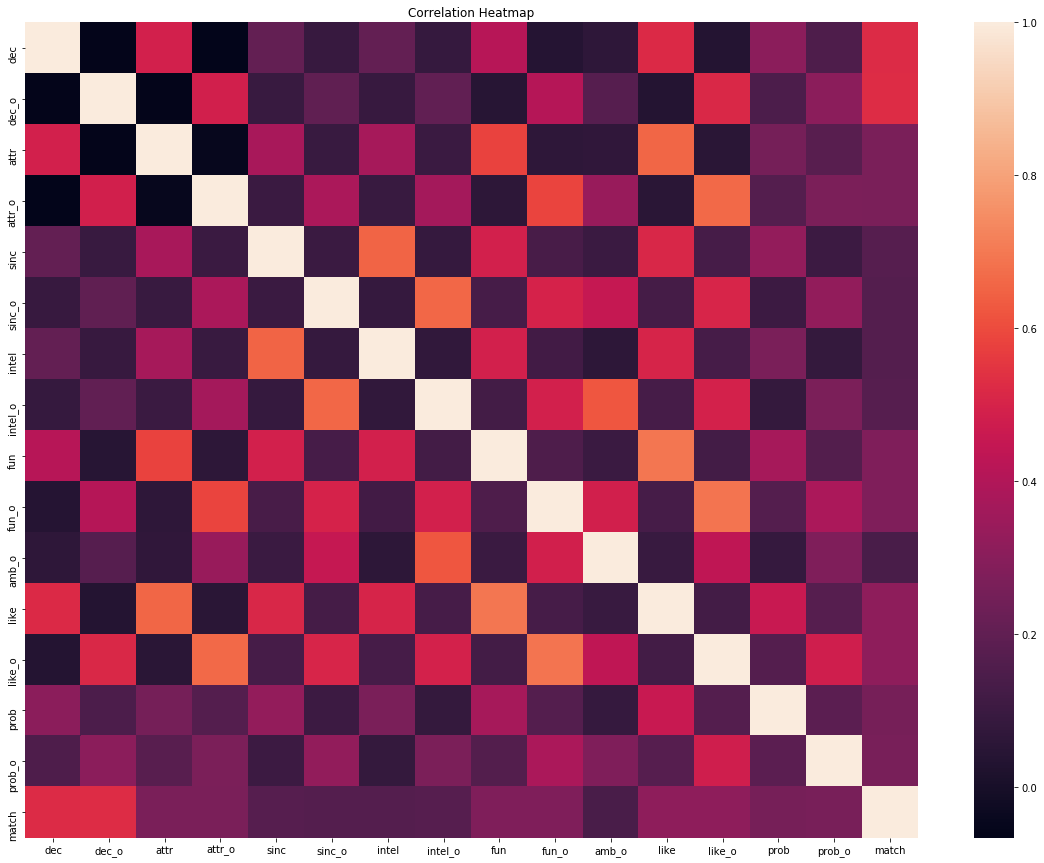

In [18]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = data1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [60]:
attr_m=df[['iid','attr_o']].groupby(['iid']).mean()
attr_self=df[['iid','attr3_1']].groupby(['iid']).mean()
dev=attr_self['attr3_1']-attr_m['attr_o']
std_dev=dev.values.tolist()
part_dec=df[['iid','dec']].groupby(['iid']).count()
p_d=part_dec.values.tolist()

In [62]:
f=np.column_stack((p_d,dev))
d=pd.DataFrame(f,columns=['num_matches','std_dev'])


In [63]:
over_est=d[d['std_dev']>0]
ov=over_est['num_matches'].shape
print('Number of people who over-estimated their attractiveness:'+str(ov[0]))
un_est=d[d['std_dev']<0]
un=un_est['num_matches'].shape
print('Number of people who under-estimated their attractiveness:'+str(un[0]))
pr_est=d[d['std_dev']==0]
pr=pr_est['num_matches'].shape
print('Number of people who properly estimated their attractiveness:'+str(pr[0]))

Number of people who over-estimated their attractiveness:397
Number of people who under-estimated their attractiveness:137
Number of people who properly estimated their attractiveness:8


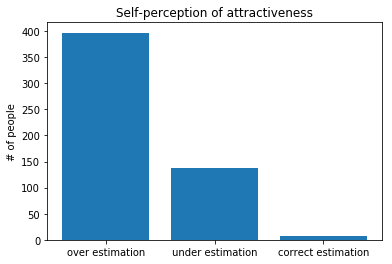

In [64]:
num=np.hstack([ov,un,pr])
fig, ax = plt.subplots()
labels=np.array(['over estimation','under estimation','correct estimation'])
ax.set_xticklabels(labels)
plt.bar(labels,num)
plt.ylabel('# of people')
plt.title('Self-perception of attractiveness')
plt.show()
# TODO plot both genders, effect on match

## ADASYN- Oversampling

#### The dataset is not balanced-

In [65]:
class_counts=df["match"].value_counts()
x=np.array(range(df.shape[0]))
print(class_counts)

0    6998
1    1380
Name: match, dtype: int64


In [147]:
def class_counts(classes):
    a = [0,0]
    for c in classes:
        a[int(c)] += 1
        count = {0 : a[0], 1: a[1]}
    return count

In [142]:
def adasamp(X,y):
    sm = ADASYN()
    y_=y
    print("Distribution of datapoints in the given dataset: ", class_counts(y_))
    X, y = sm.fit_sample(X, y)
    #print(y.shape,y_.shape)
    print("Distribution of datapoints after ADASYN Resampling: ", class_counts(y))
    return(X,y)

## Classification using random forest

In [321]:
def RF(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,50]
    count=1
    for dep in depth_values:        
        estim=[5,10,20]
        for n in estim:
            rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep,class_weight = "balanced")
            rf_clf.fit(X_train,y_train)
            y_coef=rf_clf.feature_importances_
            
            y_pred=rf_clf.predict(X_test)
            trauc=rf_clf.predict_proba(X_train)[:,1]
            cvauc=rf_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
            #print(f'{count}. depth={dep},estim={n} cv accuracy={cv_auc}')
    #print(cv_auc)
    return  tr_auc,cv_auc

In [322]:
def heatmap_plot(auc_tr,auc_cv):
    cm_pred=auc_cv
    depth_values=[1,5,10,20,50]
    estim=[5,10,20]
    cm = pd.DataFrame(auc_cv, index =depth_values, columns = estim)
    #auc_hm=cm.pivot()
    plt.figure(figsize = (5,3))
    sns.heatmap(cm, annot=True)

In [323]:
def test_RandomForest(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=RandomForestClassifier(n_estimators=n,criterion='gini', max_depth=dep, class_weight = "balanced")
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    test_auc=auc(test_fpr, test_tpr)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

In [ ]:
##########################################

#### Features=like,dec

In [148]:
X=data[['like','dec']]
y=data['match']
X,y=adasamp(X,y)
X_1, X_test_ld, y_1, y_test_ld = train_test_split(X, y, test_size=0.2, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ld, X_cv_ld, y_train_ld, y_cv_ld = train_test_split(X_1, y_1, test_size=0.2)

Distribution of datapoints in the given dataset:  {0: 4978, 1: 1063}
Distribution of datapoints after ADASYN Resampling:  {0: 4978, 1: 4691}


In [101]:
tr_auc, cv_auc=RF(X_train_ld,y_train_ld,X_cv_ld,y_cv_ld)

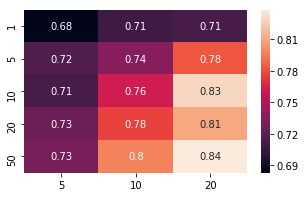

In [208]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

In [319]:
dep=10
n=20

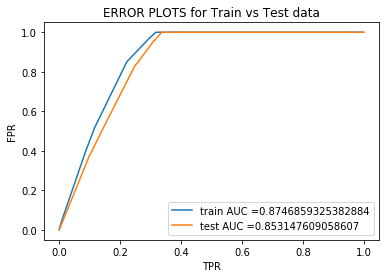

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [320]:
cf_rf2,auc_rf2=test_RandomForest(X_train_ld,y_train_ld,X_test_ld,y_test_ld,dep,n)

In [211]:
#Precision
pr=(cf[0,1]/(cf[0,1]+cf[0,0]))
print(pr*100)

33.70221327967807


In [ ]:
##########################################################

In [ ]:
#TODO cross-validation

#### Features=like,fun,int_corr

In [282]:
X=data[['like','fun','int_corr']]
y=data['match']
X,y=adasamp(X,y)
X_1, X_test_ldfi, y_1, y_test_ldfi = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ldfi, X_cv_ldfi, y_train_ldfi, y_cv_ldfi = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 4978, 1: 1063}
Distribution of datapoints after ADASYN Resampling:  {0: 4978, 1: 4740}


In [283]:
tr_auc, cv_auc=RF(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

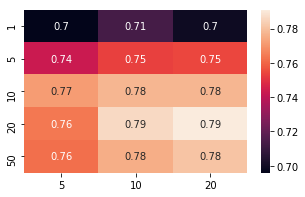

In [284]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

In [285]:
dep=10
n=20

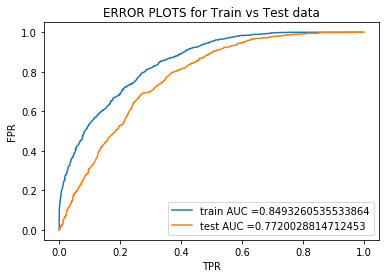

Train confusion matrix
[[1631  808]
 [ 348 1974]]
Test confusion matrix
[[ 915  586]
 [ 273 1142]]


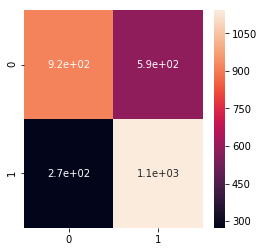

In [301]:
cf_rf,auc_rf=test_RandomForest(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

In [287]:
#Precision
pr_rf=(cf_rf[0,1]/(cf_rf[0,1]+cf_rf[0,0]))
print(pr_rf*100)

37.10859427048634


In [313]:
X=data3[['gender', 'attr_o', 'sinc_o', 'intel_o', 'shar_o', 'prob_o', 'race', 'imprace', 'goal', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr', 'sinc', 'fun', 'amb', 'shar', 'prob']]
y=data3['dec']
X,y=adasamp(X,y)
X_1, X_test_ldfi, y_1, y_test_ldfi = train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_train_ldfi, X_cv_ldfi, y_train_ldfi, y_cv_ldfi = train_test_split(X_1, y_1, test_size=0.3)

Distribution of datapoints in the given dataset:  {0: 3126, 1: 2435}
Distribution of datapoints after ADASYN Resampling:  {0: 3126, 1: 2718}


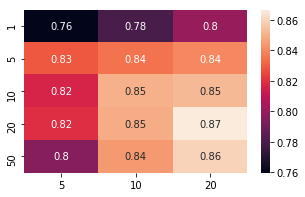

In [314]:
tr_auc_dec, cv_auc_dec=RF(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

cv_auc_dec=np.asarray(cv_auc_dec)
cv_auc_dec=cv_auc_dec.reshape(5,3)
heatmap_plot(tr_auc_dec, cv_auc_dec)

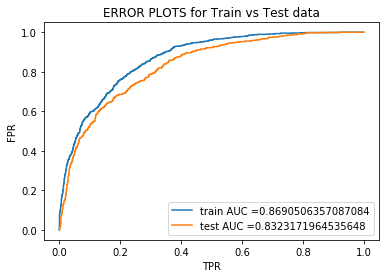

Train confusion matrix
[[1200  345]
 [ 280 1038]]
Test confusion matrix
[[717 210]
 [237 590]]


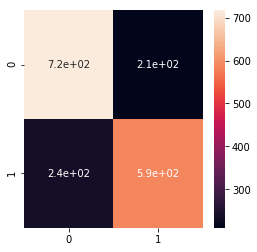

In [315]:
dep=5
n=20

cf_rf_dec,auc_rf_dec=test_RandomForest(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

In [316]:
pr_rf_dec=(cf_rf_dec[0,1]/(cf_rf_dec[0,1]+cf_rf_dec[0,0]))
print(pr_rf_dec*100)

22.653721682847898


## XGBoost

In [288]:
def xgb_train(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    depth_values=[1,5,10,20,100]
    count=1
    for dep in depth_values:        
        estim=[5, 50, 100]
        for n in estim:
            xgb_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
            xgb_clf.fit(X_train,y_train)
            #y_coef=rf_clf.feature_importances_
            #print(f'{count}. depth={dep},estim={n} running...')
            y_pred=xgb_clf.predict(X_test)
            trauc=xgb_clf.predict_proba(X_train)[:,1]
            cvauc=xgb_clf.predict_proba(X_test)[:,1]
            
            
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count +=1
    #print(cv_auc)
    return  tr_auc,cv_auc

In [289]:
def test_xgb(X_train,y_train,X_test,y_test,dep,n):
    rf_clf=xgb.XGBClassifier(max_depth=dep,n_estimators=n)
    rf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_clf.predict_proba(X_test)[:,1])
    
    test_auc=auc(test_fpr, test_tpr)
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

In [290]:
tr_auc, cv_auc=xgb_train(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

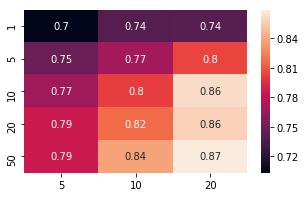

In [291]:
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(5,3)
heatmap_plot(tr_auc, cv_auc)

In [292]:
n=10
dep=10

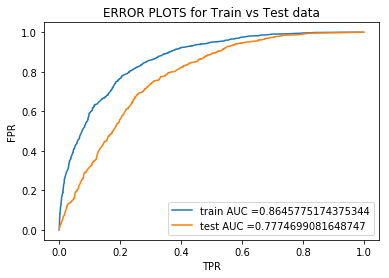

Train confusion matrix
[[1794  645]
 [ 396 1926]]
Test confusion matrix
[[1003  498]
 [ 323 1092]]


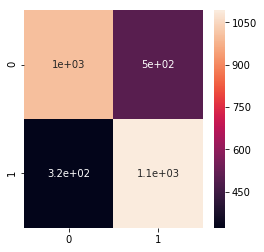

In [297]:
cf_xgb,auc_xgb=test_xgb(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,dep,n)

In [298]:
#Precision
pr_xgb=(cf_xgb[0,1]/(cf_xgb[0,1]+cf_xgb[0,0]))
print(pr_xgb*100)

33.17788141239174


## SVC

In [232]:
def svc_train(X_train,y_train,X_test,y_test):
    tr_auc=[]
    cv_auc=[]
    count=1
    for g in range(-4,4):
        gam=math.pow(10,g)
        for i in range(-4,4):            
            c=math.pow(10,i)
            print(f'{count}. c={c},g={gam} running...')
            rbf_clf=SVC(C=c, kernel='rbf', gamma=gam,probability=True,class_weight='balanced')
            rbf_clf.fit(X_train,y_train)
            #rbf_clf.probability=True
            y_rbf=rbf_clf.predict(X_test)
            #y_coef=rbf_clf.dual_coef_
            trauc=rbf_clf.predict_proba(X_train)[:,1]
            cvauc=rbf_clf.predict_proba(X_test)[:,1]
            #print(roc_auc_score(y_train,trauc))
            tr_auc.append(roc_auc_score(y_train,trauc))
            cv_auc.append(roc_auc_score(y_test,cvauc))
            count+=1
    print(count)
    print(len(tr_auc),len(cv_auc))
    return tr_auc,cv_auc

In [224]:
def plot_svc_train(title_plot,train_auc,cv_auc):
    al=range(0,64)
    plt.plot(al, train_auc, label='Train AUC')
    plt.plot(al, cv_auc, label='CV AUC')
    plt.legend()
    plt.xlabel("Alpha")
    plt.ylabel("AUC")
    plt.title(title_plot)
    plt.show()

In [225]:
def plot_heatmap1(auc_tr,auc_cv):
    cm_pred=auc_cv
    cm = pd.DataFrame(auc_cv, index = [i for i in range(-4,4)],
                  columns = [i for i in range(-4,4)])
    plt.figure(figsize = (8,8))
    sns.heatmap(cm, annot=True)

In [276]:
def test_rbf(X_train,y_train,X_test,y_test,c,gam):
    alph=math.pow(10,c)
    rbf_clf=SVC(C=c, kernel='rbf',gamma=gam,probability=True,class_weight='balanced')
    rbf_clf.fit(X_train,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, rbf_clf.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, rbf_clf.predict_proba(X_test)[:,1])
    test_auc=auc(test_fpr, test_tpr)
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ERROR PLOTS for Train vs Test data")
    plt.show()
    
    cm_pred=rbf_clf.predict(X_test)
    print("Train confusion matrix")
    print(confusion_matrix(y_train, rbf_clf.predict(X_train)))
    print("Test confusion matrix")
    print(confusion_matrix(y_test, rbf_clf.predict(X_test)))
    conf_mat = confusion_matrix(y_test,cm_pred)
    cm = pd.DataFrame(conf_mat, index = [i for i in "01"],
                  columns = [i for i in "01"])
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot=True)
    return conf_mat,test_auc

In [233]:
tr_auc, cv_auc=svc_train(X_train_ldfi,y_train_ldfi,X_cv_ldfi,y_cv_ldfi)

1. c=0.0001,g=0.0001 running...
2. c=0.001,g=0.0001 running...
3. c=0.01,g=0.0001 running...
4. c=0.1,g=0.0001 running...
5. c=1.0,g=0.0001 running...
6. c=10.0,g=0.0001 running...
7. c=100.0,g=0.0001 running...
8. c=1000.0,g=0.0001 running...
9. c=0.0001,g=0.001 running...
10. c=0.001,g=0.001 running...
11. c=0.01,g=0.001 running...
12. c=0.1,g=0.001 running...
13. c=1.0,g=0.001 running...
14. c=10.0,g=0.001 running...
15. c=100.0,g=0.001 running...
16. c=1000.0,g=0.001 running...
17. c=0.0001,g=0.01 running...
18. c=0.001,g=0.01 running...
19. c=0.01,g=0.01 running...
20. c=0.1,g=0.01 running...
21. c=1.0,g=0.01 running...
22. c=10.0,g=0.01 running...
23. c=100.0,g=0.01 running...
24. c=1000.0,g=0.01 running...
25. c=0.0001,g=0.1 running...
26. c=0.001,g=0.1 running...
27. c=0.01,g=0.1 running...
28. c=0.1,g=0.1 running...
29. c=1.0,g=0.1 running...
30. c=10.0,g=0.1 running...
31. c=100.0,g=0.1 running...
32. c=1000.0,g=0.1 running...
33. c=0.0001,g=1.0 running...
34. c=0.001,g=1.0 r

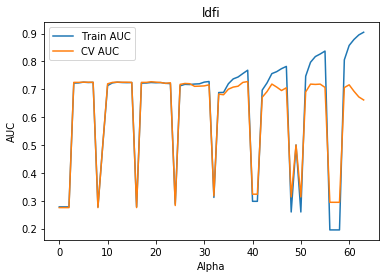

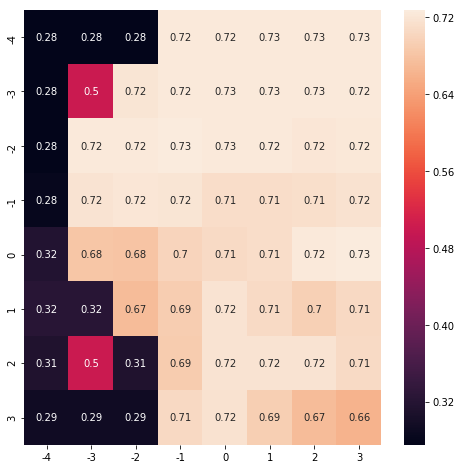

In [235]:
plot_name='ldfi'
cv_auc=np.asarray(cv_auc).reshape(64,1)
#print(bow_cv_auc)
plot_svc_train(plot_name,tr_auc, cv_auc)
cv_auc=np.asarray(cv_auc)
cv_auc=cv_auc.reshape(8,8)
#print(cv_auc.shape)
plot_heatmap1(tr_auc, cv_auc)

In [270]:
#alpha=11
c=1
gam=1000

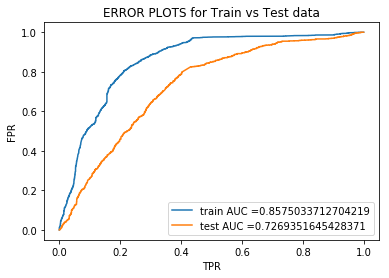

Train confusion matrix
[[1780  636]
 [ 344 2001]]
Test confusion matrix
[[ 961  540]
 [ 378 1037]]


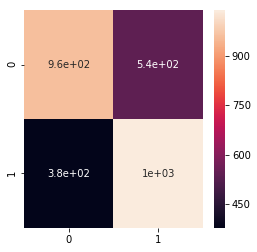

In [278]:
cf_svm,svm_auc=test_rbf(X_train_ldfi,y_train_ldfi,X_test_ldfi,y_test_ldfi,c,gam)

In [275]:
#Precision
pr=(cf_svm[0,1]/(cf_svm[0,1]+cf_svm[0,0]))
print(pr*100)

35.97601598934044


In [303]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","AUC","Precision"]

x.add_row(["RF" , auc_rf,pr_rf])
x.add_row(["XGB" ,auc_xgb,pr_xgb])
x.add_row(["SVC", svm_auc, pr])
print(x)

+-------+--------------------+---------------------+
| Model |        AUC         |      Precision      |
+-------+--------------------+---------------------+
|   RF  | 0.7720028814712453 | 0.37108594270486345 |
|  XGB  | 0.7774699081648747 |  0.3317788141239174 |
|  SVC  | 0.7269351645428371 |  0.3597601598934044 |
+-------+--------------------+---------------------+


## Recommendation